# Sentiment Analysis : To Vaccinate or Not to Vaccinate

### Intsalling packages

In [4]:
pip install contractions

In [5]:
pip install datasets

In [6]:
pip install transformers

In [7]:
pip install accelerate -U

### Importing Modules

In [8]:
# loading modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from fastai.text import *
import contractions
import warnings
import wordcloud as wc

import os
from datasets import load_dataset


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

plt.style.use('fivethirtyeight')

warnings.simplefilter("ignore")

In [10]:
# Load the data

test = pd.read_csv("../data/Test.csv").dropna(0)
train = pd.read_csv("../data/Train.csv").fillna("")

In [11]:
test.head(3)

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."


In [12]:
train.head(3)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0


## Data Cleaning

### Cleaning test training

In [13]:
text = test["safe_text"]
text

0       <user> <user> ... &amp; 4 a vaccine given 2 he...
1       Students starting school without whooping coug...
2       I'm kinda over every ep of <user> being "rippe...
3       How many innocent children die for lack of vac...
4       CDC eyeing bird flu vaccine for humans, though...
                              ...                        
5172    jenny mccarthy is on new years rockin eve. wha...
5173    Measles reported in Clark Co. for 1st time sin...
5174    <user> issues alert regarding Measles in TX. K...
5175    I can't believe people don't vaccinate their k...
5176    "<user>  Alternatives to #Flu Vaccine <url> #n...
Name: safe_text, Length: 5176, dtype: object

In [14]:
# replacing unnccessary words
text = text.replace("<user>", '', regex=True)
text = text.replace("<url>", '', regex=True)
text.head(5)

0      ... &amp; 4 a vaccine given 2 healthy peeps,...
1    Students starting school without whooping coug...
2    I'm kinda over every ep of  being "ripped from...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [15]:
text = text.astype(str)
text.head(5)

0      ... &amp; 4 a vaccine given 2 healthy peeps,...
1    Students starting school without whooping coug...
2    I'm kinda over every ep of  being "ripped from...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [16]:
text = text.apply(lambda x: x.lstrip())
text.head(5)

0    ... &amp; 4 a vaccine given 2 healthy peeps, F...
1    Students starting school without whooping coug...
2    I'm kinda over every ep of  being "ripped from...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [17]:
# changing abrevations to normal text
text= text.apply(lambda x : contractions.fix(x))
text.head(5)

0    ... &amp; 4 a vaccine given 2 healthy peeps, F...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being "ripped f...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [18]:
# removing unncessacry punctuations
text = text.replace('[^a-zA-Z0-9 ]', '', regex=True)
text.head(5)

0     amp 4 a vaccine given 2 healthy peeps FDA thi...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [19]:
# replacing the cleaned column
train["safe_text"] = text
train["safe_text"].head(5)

0     amp 4 a vaccine given 2 healthy peeps FDA thi...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [20]:
# Drop Null records
test = test.dropna(axis=1, how='all')
test.head(5)

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [21]:
# Drop duplicated records
test = test.drop_duplicates()
test.head(5)

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [22]:
# Check for null values
test.isna().sum()

tweet_id     0
safe_text    0
dtype: int64

Test data is now cleaned...

## Cleaning training data

In [23]:
text = train["safe_text"]
text

0         amp 4 a vaccine given 2 healthy peeps FDA thi...
1        Students starting school without whooping coug...
2        I am kind of over every ep of  being ripped fr...
3        How many innocent children die for lack of vac...
4        CDC eyeing bird flu vaccine for humans though ...
                               ...                        
9996                                                   NaN
9997                                                   NaN
9998                                                   NaN
9999                                                   NaN
10000                                                  NaN
Name: safe_text, Length: 10001, dtype: object

In [24]:
# replacing unnccessary words
text = text.replace("<user>", '', regex=True)
text = text.replace("<url>", '', regex=True)
text.head(5)

0     amp 4 a vaccine given 2 healthy peeps FDA thi...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [25]:
text = text.astype(str)
text.head(5)

0     amp 4 a vaccine given 2 healthy peeps FDA thi...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [26]:
text = text.apply(lambda x: x.lstrip())
text.head(5)

0    amp 4 a vaccine given 2 healthy peeps FDA thin...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [27]:
# changing abrevations to normal text
text= text.apply(lambda x : contractions.fix(x))
text.head(5)

0    amp 4 a vaccine given 2 healthy peeps FDA thin...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [28]:
# removing unncessacry punctuations
text = text.replace('[^a-zA-Z0-9 ]', '', regex=True)
text.head(5)

0    amp 4 a vaccine given 2 healthy peeps FDA thin...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [29]:
# Check for null values
train.isna().sum()

tweet_id        0
safe_text    4825
label           0
agreement       0
dtype: int64

In [30]:
# Drop Null records
train = train.dropna()
train.head(5)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,amp 4 a vaccine given 2 healthy peeps FDA thi...,0.0,1.0
1,E3303EME,Students starting school without whooping coug...,1.0,1.0
2,M4IVFSMS,I am kind of over every ep of being ripped fr...,-1.0,1.0
3,1DR6ROZ4,How many innocent children die for lack of vac...,-1.0,1.0
4,J77ENIIE,CDC eyeing bird flu vaccine for humans though ...,0.0,1.0


In [31]:
# replacing the continous value to 1
train["label"] = train["label"].replace(0.6666666666666666 , 1)
train["label"].unique()

array([0.0, 1.0, -1.0, ''], dtype=object)

In [32]:
train["label"] = train["label"].replace("" , 0)
train["label"].unique()

array([ 0.,  1., -1.])

### Agreement column

In [33]:
train["agreement"].unique()

array([1.0, 0.6666666666666666, 0.3333333333333333, ''], dtype=object)

In [34]:
train["agreement"] = train["agreement"].replace("", 0)

In [35]:
train.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

Train data is now cleaned...

## Exploratory Data Analysis

In [36]:
train.head(5)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,amp 4 a vaccine given 2 healthy peeps FDA thi...,0.0,1.0
1,E3303EME,Students starting school without whooping coug...,1.0,1.0
2,M4IVFSMS,I am kind of over every ep of being ripped fr...,-1.0,1.0
3,1DR6ROZ4,How many innocent children die for lack of vac...,-1.0,1.0
4,J77ENIIE,CDC eyeing bird flu vaccine for humans though ...,0.0,1.0


### Number of responses given to text

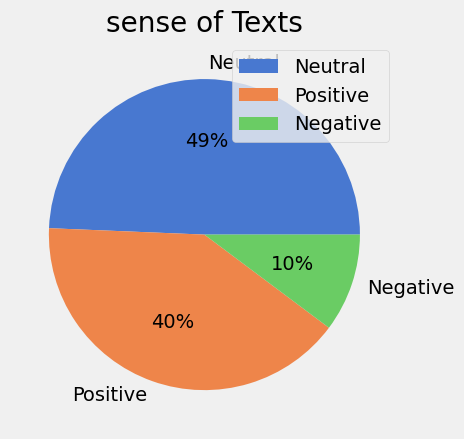

<Figure size 1000x500 with 0 Axes>

In [37]:
# Define the data and labels for the pie chart
data = train["label"].value_counts()
labels = ['Neutral', 'Positive', 'Negative']

# Choose a Seaborn color palette
colors = sns.color_palette('muted')

# Create the pie chart with Matplotlib
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')

# Add a title and a legend to the pie chart
plt.title('sense of Texts')
plt.legend(loc='upper right')

# Adjusting size
plt.figure(figsize=(10, 5))

# Show the pie chart
plt.show()


In [38]:
train.agreement.unique()

array([1.        , 0.66666667, 0.33333333, 0.        ])

# Reviewed Text Sentiment

In [39]:
data = train
data["agreement"] = train["agreement"].round(2)

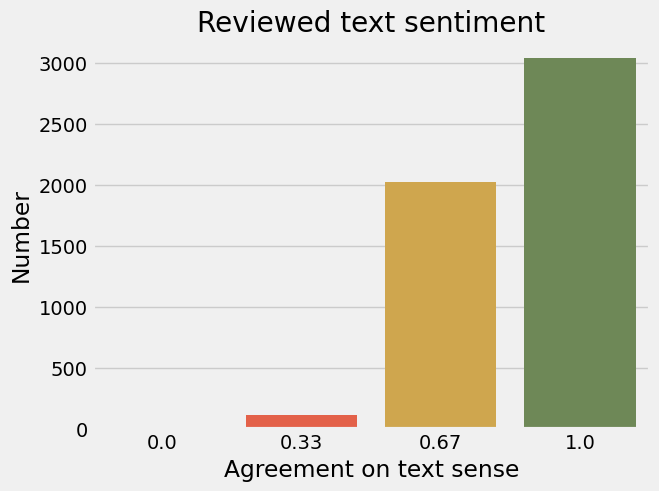

In [40]:
# Create a bar chart with Seaborn
sns.countplot(x="agreement", data=data)

# Add labels and title to the chart
plt.xlabel("Agreement on text sense")
plt.ylabel("Number")
plt.title("Reviewed text sentiment")

# Show the chart
plt.show()


### Visualizing Words from the dataset

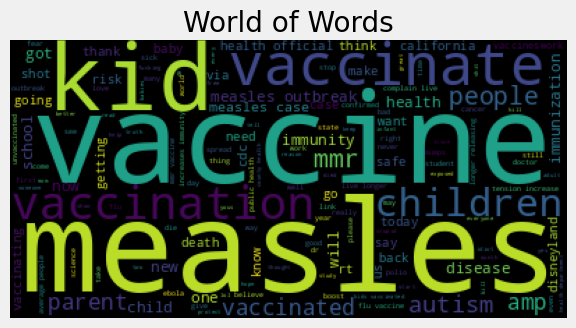

In [41]:
# Extract the texts column as a Series object
texts = train['safe_text']

# Convert the texts to lowercase and join them into a single string
text = texts.str.lower().str.cat(sep=' ')

# Create a word cloud object with the WordCloud() function and pass in the text
cloud = wc.WordCloud().generate(text)

# Display the word cloud with matplotlib using the imshow() and show() functions
plt.imshow(cloud)
plt.axis('off')
plt.title("World of Words")
plt.show()


# Sentiment Analysis

In [42]:
from nltk import download

# Download stopwords, execute it just once then may comment
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
df = train

In [44]:
df["safe_text"].head()

0     amp 4 a vaccine given 2 healthy peeps FDA thi...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [45]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')

stemmer = PorterStemmer()

# breaking down words into tokens
df['tokens'] = df['safe_text'].apply(lambda df: word_tokenize(df, preserve_line=True))
df["tokens"]

0       [amp, 4, a, vaccine, given, 2, healthy, peeps,...
1       [Students, starting, school, without, whooping...
2       [I, am, kind, of, over, every, ep, of, being, ...
3       [How, many, innocent, children, die, for, lack...
4       [CDC, eyeing, bird, flu, vaccine, for, humans,...
                              ...                        
5172    [jenny, mccarthy, is, on, new, years, rockin, ...
5173    [Measles, reported, in, Clark, Co, for, 1st, t...
5174    [issues, alert, regarding, Measles, in, TX, Ke...
5175    [I, can, not, believe, people, do, not, vaccin...
5176    [Alternatives, to, Flu, Vaccine, natural, heal...
Name: tokens, Length: 5176, dtype: object

In [46]:
# removing punctuations or signs
df['alpha'] = df['tokens'].apply(lambda x: [item for item in x if item.isalpha()])
df["alpha"]

0       [amp, a, vaccine, given, healthy, peeps, FDA, ...
1       [Students, starting, school, without, whooping...
2       [I, am, kind, of, over, every, ep, of, being, ...
3       [How, many, innocent, children, die, for, lack...
4       [CDC, eyeing, bird, flu, vaccine, for, humans,...
                              ...                        
5172    [jenny, mccarthy, is, on, new, years, rockin, ...
5173    [Measles, reported, in, Clark, Co, for, time, ...
5174    [issues, alert, regarding, Measles, in, TX, Ke...
5175    [I, can, not, believe, people, do, not, vaccin...
5176    [Alternatives, to, Flu, Vaccine, natural, heal...
Name: alpha, Length: 5176, dtype: object

In [47]:
# removing stopwords
df['stop'] = df['alpha'].apply(lambda x: [item for item in x if item not in stop])
df["stop"]

0       [amp, vaccine, given, healthy, peeps, FDA, thi...
1       [Students, starting, school, without, whooping...
2       [I, kind, every, ep, ripped, headlines, Measle...
3       [How, many, innocent, children, die, lack, vac...
4       [CDC, eyeing, bird, flu, vaccine, humans, thou...
                              ...                        
5172    [jenny, mccarthy, new, years, rockin, eve, don...
5173          [Measles, reported, Clark, Co, time, since]
5174    [issues, alert, regarding, Measles, TX, Keep, ...
5175    [I, believe, people, vaccinate, kids, I, vacci...
5176    [Alternatives, Flu, Vaccine, natural, health, ...
Name: stop, Length: 5176, dtype: object

In [48]:
# reducing words to thier root
df['stemmed'] = df['stop'].apply(lambda x: [stemmer.stem(item) for item in x])
df["stemmed"]

0       [amp, vaccin, given, healthi, peep, fda, think...
1       [student, start, school, without, whoop, cough...
2       [i, kind, everi, ep, rip, headlin, measl, let,...
3       [how, mani, innoc, children, die, lack, vaccin...
4       [cdc, eye, bird, flu, vaccin, human, though, r...
                              ...                        
5172    [jenni, mccarthi, new, year, rockin, eve, done...
5173               [measl, report, clark, co, time, sinc]
5174    [issu, alert, regard, measl, tx, keep, ddx, da...
5175    [i, believ, peopl, vaccin, kid, i, vaccin, eve...
5176    [altern, flu, vaccin, natur, health, a, good, ...
Name: stemmed, Length: 5176, dtype: object

In [49]:
vectorizer = TfidfVectorizer(lowercase=False, analyzer=lambda x: x)
tf_idf = vectorizer.fit_transform(df['stemmed']).toarray()
feature_names = list(vectorizer.vocabulary_.keys())
pd.DataFrame(tf_idf, columns=feature_names).head()

,amp,vaccin,given,healthi,peep,fda,think,worth,ae,risk,...,kp,interrupt,strongsvil,doesntgetanybett,rockin,besid,goddamn,ddx,emergencymedicin,jerf
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(tf_idf, df['label'], test_size=0.2, random_state=42)

### Logistic Regression

In [51]:
# Train the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [52]:
# Predict using the trained model
y_pred_lr = lr.predict(X_test)

# Estimate some metrics
print('accuracy:', accuracy_score(y_pred_lr, y_test))
print('rmse:', mean_squared_error(y_pred_lr, y_test, squared=False))

accuracy: 0.44305019305019305
rmse: 0.8166935881886285


In [53]:
# All distinct values that have been predicted
np.unique(y_pred_lr)

array([-1.,  0.,  1.])

In [54]:
# Train the model
model = SVC()
model.fit(X_train, y_train)

SVC()

In [55]:
# Predict using the trained model
y_pred = model.predict(X_test)

# Estimate some metrics
print('accuracy:', accuracy_score(y_pred, y_test))
print('rmse:', mean_squared_error(y_pred, y_test, squared=False))

accuracy: 0.46525096525096526
rmse: 0.7584784606629085


# Finetuning a pretrain Hugging Face model

In [56]:
# Disabe W&B servers to accept any information
os.environ["WANDB_DISABLED"] = "true"

In [57]:
# Split the train data => {train, eval} by saving proportion of "label" column
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [58]:
train.head()

,tweet_id,safe_text,label,agreement,tokens,alpha,stop,stemmed
5,OVNPOAUX,I think that active duty soldiers should get v...,1.0,0.67,"[I, think, that, active, duty, soldiers, shoul...","[I, think, that, active, duty, soldiers, shoul...","[I, think, active, duty, soldiers, get, vaccin...","[i, think, activ, duti, soldier, get, vaccin, ..."
1079,UARXNKNI,if it was not a money grab they would let you ...,0.0,1.00,"[if, it, was, not, a, money, grab, they, would...","[if, it, was, not, a, money, grab, they, would...","[money, grab, would, let, space, shots, instea...","[money, grab, would, let, space, shot, instead..."
4250,KFMG3MRK,On average people who complain live longerRel...,0.0,1.00,"[On, average, people, who, complain, live, lon...","[On, average, people, who, complain, live, lon...","[On, average, people, complain, live, longerRe...","[on, averag, peopl, complain, live, longerrele..."
3045,V8K3C408,NF Thanks fort the follow MMR,1.0,1.00,"[NF, Thanks, fort, the, follow, MMR]","[NF, Thanks, fort, the, follow, MMR]","[NF, Thanks, fort, follow, MMR]","[nf, thank, fort, follow, mmr]"
2808,BIJW6Q5D,Add coconuts salmon eggs and olive oil to your...,1.0,0.67,"[Add, coconuts, salmon, eggs, and, olive, oil,...","[Add, coconuts, salmon, eggs, and, olive, oil,...","[Add, coconuts, salmon, eggs, olive, oil, diet...","[add, coconut, salmon, egg, oliv, oil, diet, h..."


In [59]:
eval.head()

,tweet_id,safe_text,label,agreement,tokens,alpha,stop,stemmed
1494,N74ZZ5O8,Like Ebola and the Measles it is coming Valent...,0.0,1.00,"[Like, Ebola, and, the, Measles, it, is, comin...","[Like, Ebola, and, the, Measles, it, is, comin...","[Like, Ebola, Measles, coming, Valentines, Yuc...","[like, ebola, measl, come, valentin, yuck, val..."
2531,JUV233VU,the fact that you are following measles me day...,1.0,1.00,"[the, fact, that, you, are, following, measles...","[the, fact, that, you, are, following, measles...","[fact, following, measles, day, amazing]","[fact, follow, measl, day, amaz]"
1029,CZG4UOK0,Texas health officials issue measles alert Tex...,1.0,1.00,"[Texas, health, officials, issue, measles, ale...","[Texas, health, officials, issue, measles, ale...","[Texas, health, officials, issue, measles, ale...","[texa, health, offici, issu, measl, alert, tex..."
1230,86EWXZGR,I am sure she is nice but also a dangerous idi...,0.0,0.67,"[I, am, sure, she, is, nice, but, also, a, dan...","[I, am, sure, she, is, nice, but, also, a, dan...","[I, sure, nice, also, dangerous, idiot, spouts...","[i, sure, nice, also, danger, idiot, spout, ha..."
1845,7XQCN4DD,Having kids immunized me to kids screeches sc...,0.0,0.67,"[Having, kids, immunized, me, to, kids, screec...","[Having, kids, immunized, me, to, kids, screec...","[Having, kids, immunized, kids, screeches, scr...","[have, kid, immun, kid, screech, scream, year,..."


In [60]:
# Save splitted subsets
train.to_csv("../content/drive/MyDrive/data/train_subset.csv", index=False)
eval.to_csv("../content/drive/MyDrive/data/eval_subset.csv", index=False)

In [61]:
dataset = load_dataset('csv',
                        data_files={'train': '../content/drive/MyDrive/data/train_subset.csv',
                        'eval': '../content/drive/MyDrive/data/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [62]:
# Import pretrained model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased' , use_fast=True)

In [63]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [64]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

In [65]:
# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/4140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Map:   0%|          | 0/4140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

In [66]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'alpha', 'stop', 'stemmed', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4140
    })
    eval: Dataset({
        features: ['tokens', 'alpha', 'stop', 'stemmed', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1036
    })
})

In [67]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments(
                                  "test_trainer",
                                  num_train_epochs=25,
                                  load_best_model_at_end=True,
                                  evaluation_strategy="steps",
                                  save_strategy="steps",
                                  eval_steps=10, save_steps=10
                                 )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [68]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

In [70]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [72]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Launch the learning process: training
trainer.train()

Step,Training Loss,Validation Loss
10,No log,0.982746
